In [4]:
import scipy
import numpy as np
import matplotlib.pyplot as plt

# Gaussian process posterior
def GP(X1, y1, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve K_12.T @ K_11.inv
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

In [2]:
# Define the exponentiated quadratic 
def exponentiated_quadratic(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

- 数学基础（零均值、无噪声 GP 后验）：

先验：$ f \sim \mathcal{GP}(0, k(\cdot, \cdot)) $
联合分布：
$$\begin{bmatrix} \mathbf{y}_1 \\ \mathbf{f}_2 \end{bmatrix} \sim \mathcal{N}\left( \mathbf{0}, \begin{bmatrix} K_{11} & K_{12} \\ K_{21} & K_{22} \end{bmatrix} \right)$$
其中 $ K_{11} = k(X1, X1) $，$ K_{12} = k(X1, X2) $，$ K_{21} = K_{12}^T $，$ K_{22} = k(X2, X2) $。
后验：$ \mathbf{f}_2 \mid \mathbf{y}_1 \sim \mathcal{N}(\bar{\mathbf{f}}_2, \Sigma_2) $，其中：
$$\bar{\mathbf{f}}_2 = K_{12}^T K_{11}^{-1} \mathbf{y}_1$$
$$\Sigma_2 = K_{22} - K_{12}^T K_{11}^{-1} K_{12}$$



- Note：

无噪声：训练点上会精确插值（后验均值 = 观测值）。
使用 scipy.linalg.solve 避免直接求逆，提高数值稳定性（利用正定性）。
假设核矩阵正定（assume_a='pos'）。

- 涵义

| 步骤 | 代码 | 数学含义 | 形状变化 |
|------|------|----------|----------|
| 1 | `Σ11 = kernel_func(X1, X1)` | $ K_{11} $ | (n, n) |
| 2 | `Σ12 = kernel_func(X1, X2)` | $ K_{12} $ | (n, m) |
| 3 | `solved = solve(...).T` | $ K_{12}^T K_{11}^{-1} $ | (m, n) |
| 4 | `μ2 = solved @ y1` | $ K_{12}^T K_{11}^{-1} \mathbf{y}_1 $ | (m,) |
| 5 | `Σ22 = kernel_func(X2, X2)` | $ K_{22} $ | (m, m) |
| 6 | `Σ2 = Σ22 - solved @ Σ12` | $ K_{22} - K_{12}^T K_{11}^{-1} K_{12} $ | (m, m) |

<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\m'
<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\m'
/var/folders/n3/5t978bxj59ddk47g5b0wqg4h0000gn/T/ipykernel_71826/2248411213.py:26: SyntaxWarning: invalid escape sequence '\s'
  alpha=0.15, label='$2 \sigma_{2|1}$')
/var/folders/n3/5t978bxj59ddk47g5b0wqg4h0000gn/T/ipykernel_71826/2248411213.py:27: SyntaxWarning: invalid escape sequence '\m'
  ax1.plot(X2, μ2, 'r-', lw=2, label='$\mu_{2|1}$')


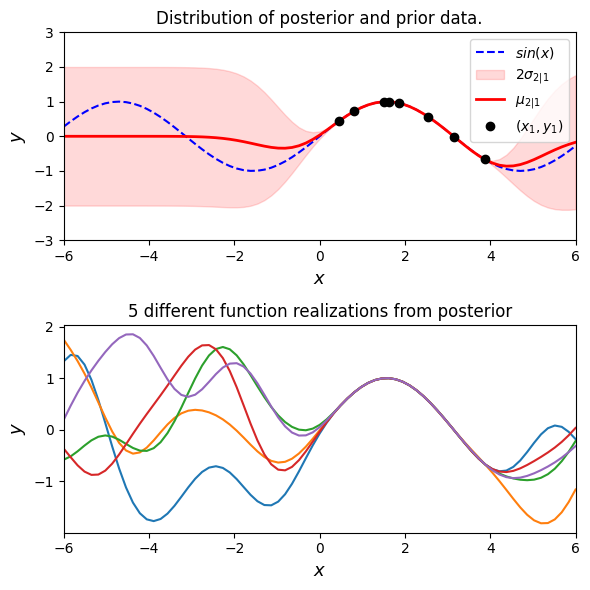

In [5]:
f_sin = lambda x: (np.sin(x)).flatten()

n1 = 8  # Number of points to condition on (training points)
n2 = 75  # Number of points in posterior (test points)
ny = 5  # Number of functions that will be sampled from the posterior
domain = (-6, 6)

# Sample observations (X1, y1) on the function
X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n1, 1))
y1 = f_sin(X1)
# Predict points at uniform spacing to capture function
X2 = np.linspace(domain[0], domain[1], n2).reshape(-1, 1)
# Compute posterior mean and covariance
μ2, Σ2 = GP(X1, y1, X2, exponentiated_quadratic)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f_sin(X2), 'b--', label='$sin(x)$')
ax1.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color='red', 
                 alpha=0.15, label='$2 \sigma_{2|1}$')
ax1.plot(X2, μ2, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data.')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()
# Plot some samples from this function
ax2.plot(X2, y2.T, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax2.set_xlim([-6, 6])
plt.tight_layout()
plt.show()

In [ ]:
# Gaussian process posterior with noisy obeservations
def GP_noise(X1, y1, X2, kernel_func, σ_noise):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the noisy observations 
    (y1, X1), and the prior kernel function.
    """
    # Kernel of the noisy observations
    Σ11 = kernel_func(X1, X1) + ((σ_noise ** 2) * np.eye(n1))
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance



<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\m'
/var/folders/n3/5t978bxj59ddk47g5b0wqg4h0000gn/T/ipykernel_71826/3307139635.py:18: SyntaxWarning: invalid escape sequence '\s'
  alpha=0.15, label='$2\sigma_{2|1}$')
/var/folders/n3/5t978bxj59ddk47g5b0wqg4h0000gn/T/ipykernel_71826/3307139635.py:19: SyntaxWarning: invalid escape sequence '\m'
  ax1.plot(X2, μ2, 'r-', lw=2, label='$\mu_{2|1}$')


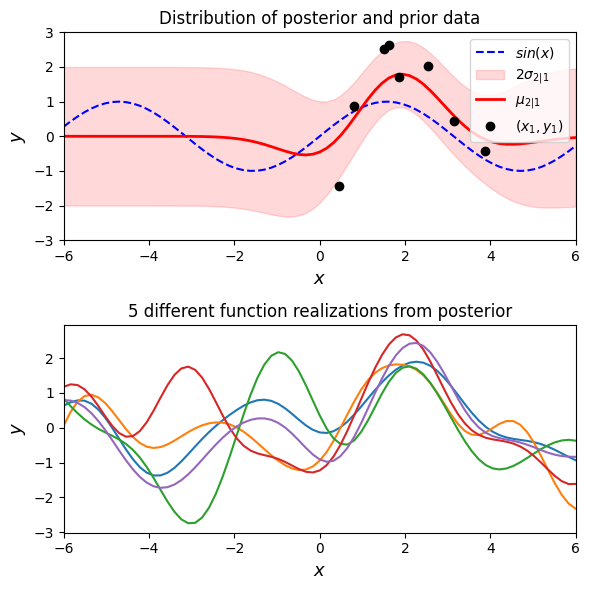

In [8]:
σ_noise = 1.0  # The standard deviation of the noise
# Add noise kernel to the samples we sampled previously
y1 = y1 + ((σ_noise ** 2) * np.random.randn(n1))

# Compute posterior mean and covariance
μ2, Σ2 = GP_noise(X1, y1, X2, exponentiated_quadratic, σ_noise)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f_sin(X2), 'b--', label='$sin(x)$')
ax1.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color='red', 
                 alpha=0.15, label='$2\sigma_{2|1}$')
ax1.plot(X2, μ2, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()
# Plot some 0samples from this function
ax2.plot(X2, y2.T, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax2.set_xlim([-6, 6])
plt.tight_layout()
plt.show()


## Tuning the hyperparameters

We can tune the hyperparameters $\theta$ of our Gaussian process model based on the data. This post leverages TensorFlow to fit the parameters by maximizing the marginal likelihood $p(\mathbf{y} \mid X, \theta)$ of the Gaussian process distribution based on the observed data $(X, \mathbf{y})$.

$$
\hat{\theta} = \arg\max_{\theta} p(\mathbf{y} \mid X, \theta)
$$

The marginal likelihood of the Gaussian process is the likelihood of a **Gaussian distribution** which is defined as:

$$
p(\mathbf{y} \mid \mu, \Sigma) = \frac{1}{\sqrt{(2\pi)^{d} |\Sigma|}} \exp\left( -\frac{1}{2} (\mathbf{y} - \mu)^T \Sigma^{-1} (\mathbf{y} - \mu) \right)
$$

The mean and covariance are calculated from their parameterized functions using the observed data $X$ as input: $\mu_{\theta} = m_{\theta}(X)$ and $\Sigma_{\theta} = k_{\theta}(X, X)$, so we can write the marginal likelihood as:

$$
p(\mathbf{y} \mid X, \theta) = \frac{1}{\sqrt{(2\pi)^{d} |\Sigma_{\theta}|}} \exp\left( -\frac{1}{2} (\mathbf{y} - \mu_{\theta})^T \Sigma_{\theta}^{-1} (\mathbf{y} - \mu_{\theta}) \right)
$$

With $d$ the dimensionality of the marginal and $|\Sigma_{\theta}|$ the determinant of the kernel matrix. We can get rid of the exponent by taking the **log** and maximizing the **log marginal likelihood**:

$$
\log p(\mathbf{y} \mid X, \theta) = -\frac{1}{2} (\mathbf{y} - \mu_{\theta})^T \Sigma_{\theta}^{-1} (\mathbf{y} - \mu_{\theta}) - \frac{1}{2} \log |\Sigma_{\theta}| - \frac{d}{2} \log 2\pi
$$

The first term $(−0.5(\mathbf{y}−\mu_{\theta})^T \Sigma_{\theta}^{-1} (\mathbf{y}−\mu_{\theta}))$ is the **data-fit** while the rest $(−0.5\log|\Sigma_{\theta}| + d\log 2\pi)$ is a **complexity penalty**, also known as **differential entropy** [¹].

The optimal parameters $\hat{\theta}$ can then be found by **minimizing the negative** of the log marginal likelihood:

$$
\hat{\theta} = \arg\max_{\theta} p(\mathbf{y} \mid X, \theta) = \arg\min_{\theta} -\log p(\mathbf{y} \mid X, \theta)
$$

Since in this case the log marginal likelihood is **derivable** with respect to the kernel hyperparameters, we can use a **gradient-based approach** to minimize the negative log marginal likelihood (NLL). In this post we will be using a **gradient descent based approach** to train the hyperparameters on minibatches of the observed data.

<>:164: SyntaxWarning: invalid escape sequence '\m'
<>:164: SyntaxWarning: invalid escape sequence '\m'
/var/folders/n3/5t978bxj59ddk47g5b0wqg4h0000gn/T/ipykernel_71826/1135991170.py:164: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(X_test_np, mu, 'b-', label='GP Mean ($\mu$)')
/var/folders/n3/5t978bxj59ddk47g5b0wqg4h0000gn/T/ipykernel_71826/1135991170.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.log_lengthscale = nn.Parameter(torch.tensor(init_log_lengthscale, dtype=torch.float32))
/var/folders/n3/5t978bxj59ddk47g5b0wqg4h0000gn/T/ipykernel_71826/1135991170.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.log_outputscale = nn.Parameter(torch.tensor(init_lo

Starting hyperparameter optimization...
step  50 | NLL = 42.2383 | lengthscale (l): 0.663 | outputscale (σ_f): 1.841 | noise_scale (σ_n): 0.251
step 100 | NLL = 35.8515 | lengthscale (l): 0.981 | outputscale (σ_f): 1.873 | noise_scale (σ_n): 0.337
step 150 | NLL = 33.6623 | lengthscale (l): 1.342 | outputscale (σ_f): 2.059 | noise_scale (σ_n): 0.394
step 200 | NLL = 33.2300 | lengthscale (l): 1.563 | outputscale (σ_f): 2.352 | noise_scale (σ_n): 0.417
step 250 | NLL = 33.1143 | lengthscale (l): 1.698 | outputscale (σ_f): 2.589 | noise_scale (σ_n): 0.424
step 300 | NLL = 33.0970 | lengthscale (l): 1.749 | outputscale (σ_f): 2.719 | noise_scale (σ_n): 0.425
step 350 | NLL = 33.0956 | lengthscale (l): 1.764 | outputscale (σ_f): 2.761 | noise_scale (σ_n): 0.425
step 400 | NLL = 33.0955 | lengthscale (l): 1.767 | outputscale (σ_f): 2.771 | noise_scale (σ_n): 0.425


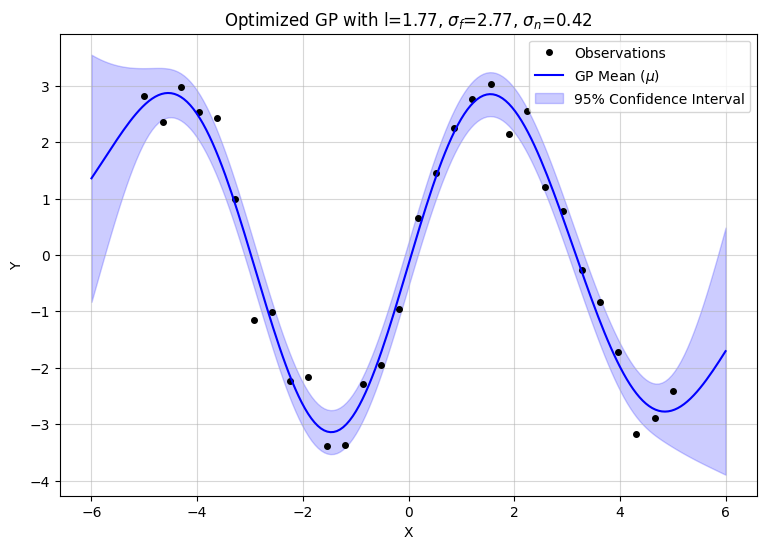

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Set seed for reproducibility
torch.manual_seed(0)

# RBF Kernel and GP Model Definition ---
class RBFKernelGP(nn.Module):
    def __init__(self, init_log_lengthscale=0., init_log_outputscale=0., init_log_noise_scale=-2.):
        super().__init__()
        
        # 1. RBF Kernel Hyperparameters (using log transform for positive constraint)
        self.log_lengthscale = nn.Parameter(torch.tensor(init_log_lengthscale, dtype=torch.float32))
        self.log_outputscale = nn.Parameter(torch.tensor(init_log_outputscale, dtype=torch.float32))
        
        # 2. Observational Noise Hyperparameter (sigma_n)
        self.log_noise_scale = nn.Parameter(torch.tensor(init_log_noise_scale, dtype=torch.float32))

    # Define properties to get the actual positive hyperparameter values
    @property
    def lengthscale(self):
        # l in RBF formula
        return torch.exp(self.log_lengthscale)

    @property
    def outputscale(self):
        # The 'sigma_f' in RBF formula (vertical scale/amplitude)
        return torch.exp(self.log_outputscale)

    @property
    def noise_scale(self):
        # The 'sigma_n' (observational noise standard deviation)
        return torch.exp(self.log_noise_scale)

    def forward(self, X1, X2):
        """Computes the RBF covariance matrix K(X1, X2)."""
        ell = self.lengthscale
        sigma_f = self.outputscale
        
        # Compute squared Euclidean distance divided by lengthscale squared
        # dist = ||X1 - X2||^2 / ell^2
        dist = torch.cdist(X1/ell, X2/ell, p=2)**2
        
        # RBF formula: sigma_f^2 * exp(-0.5 * dist)
        return sigma_f**2 * torch.exp(-0.5 * dist)

# Loss Function (Negative Marginal Log-Likelihood) ---
def neg_log_marginal_likelihood(kernel_model, X, y):
    """Calculates the Negative Marginal Log-Likelihood (NLL) to be minimized."""
    
    # K_XX: prior covariance of the function f
    K_XX = kernel_model(X, X)
    
    # Add noise to the diagonal: K_y = K_XX + sigma_n^2 * I
    noise_variance = kernel_model.noise_scale**2
    K_y = K_XX + noise_variance * torch.eye(len(X), device=X.device)
    
    # MLL = -0.5 * y_T @ K_y^-1 @ y - 0.5 * log(|K_y|) - 0.5 * N * log(2*pi)
    try:
        # Use Cholesky decomposition for stability: K_y = L L^T
        L = torch.linalg.cholesky(K_y)
        
        # 1. log(|K_y|) = 2 * sum(log(diag(L)))
        logdet_Ky_term = 2.0 * torch.sum(torch.log(torch.diag(L)))
        
        # 2. Quadrature form: y_T @ K_y^-1 @ y
        # solve for alpha = K_y^-1 @ y
        alpha = torch.cholesky_solve(y.unsqueeze(-1), L).squeeze(-1)
        quad_form_term = torch.dot(y, alpha)
        
        # NLL calculation (Negative of MLL)
        N = len(y)
        const_term = 0.5 * N * torch.log(torch.tensor(2 * torch.pi, device=X.device))
        
        # NLL = 0.5 * quad_form + 0.5 * logdet_Ky + const
        return 0.5 * quad_form_term + 0.5 * logdet_Ky_term + const_term
        
    except RuntimeError as e:
        # Catch non-positive definite matrix error (usually due to bad hyperparameters)
        if 'cholesky_cpu' in str(e) or 'cholesky_cuda' in str(e):
            print("Warning: Cholesky decomposition failed. Hyperparameters are poor. Skipping update.")
            return torch.tensor(1e10, dtype=torch.float32) # Return a large loss
        raise e

def train_gp_torch(X_np, y_np, n_steps=300, lr=0.05):
    X_t = torch.tensor(X_np, dtype=torch.float32)
    y_t = torch.tensor(y_np, dtype=torch.float32).squeeze() # Ensure y is 1D

    # Initial hyperparameter values length, outputscale, noise_scale(noise will be estimated during training)
    initial_l, initial_sf, initial_sn = 1.0, 1.0, 0.1
    init_log_l = torch.log(torch.tensor(initial_l))
    init_log_sf = torch.log(torch.tensor(initial_sf))
    init_log_sn = torch.log(torch.tensor(initial_sn))

    kernel_model = RBFKernelGP(init_log_l, init_log_sf, init_log_sn)
    
    # Optimizer for all nn.Parameters in the model
    optimizer = optim.Adam(kernel_model.parameters(), lr=lr)

    losses = []
    print("Starting hyperparameter optimization...")
    for step in range(n_steps):
        optimizer.zero_grad()
        # Calculate the current performance
        loss = neg_log_marginal_likelihood(kernel_model, X_t, y_t)
        # Compute the direction and magnitude of the steepest descent (Gradients)
        loss.backward()
        # Adjust the hyperparameters ($\ell$, $\sigma_f$, $\sigma_n$) to decrease the NLL.
        optimizer.step()

        losses.append(loss.item())
        if (step+1) % 50 == 0:
            print(f"step {step+1:3d} | NLL = {loss.item():.4f} | "
                  f"lengthscale (l): {kernel_model.lengthscale.item():.3f} | "
                  f"outputscale (σ_f): {kernel_model.outputscale.item():.3f} | "
                  f"noise_scale (σ_n): {kernel_model.noise_scale.item():.3f}")

    return kernel_model, losses

# Prediction 
if __name__ == "__main__":
    # Toy data: sin wave with noise
    X_np = np.linspace(-5, 5, 30)[:, None]
    y_np = np.sin(X_np.ravel()) * 3 + 0.5*np.random.randn(len(X_np))

    # --- Training ---
    kernel_model, losses = train_gp_torch(X_np, y_np, n_steps=400, lr=0.03)

    # --- Making Predictions ---
    X_test_np = np.linspace(-6, 6, 200)[:, None]
    X_t = torch.tensor(X_np, dtype=torch.float32)
    y_t = torch.tensor(y_np, dtype=torch.float32).squeeze()
    X_test_t = torch.tensor(X_test_np, dtype=torch.float32)
    
    # Freeze computational graph for prediction
    with torch.no_grad():
        # Core Components
        noise_variance = kernel_model.noise_scale**2
        # full covariance matrix of the training data, xx
        K_XX = kernel_model(X_t, X_t) + noise_variance * torch.eye(len(X_t))
        # cross-covariance matrix between the training data and the test data.
        K_Xs = kernel_model(X_t, X_test_t)
        # full covariance matrix of the test data.
        K_ss = kernel_model(X_test_t, X_test_t)
        
        # 1. Cholesky decomposition of K_y
        L = torch.linalg.cholesky(K_XX)
        
        # 2. Predictive Mean: mu = K_sX K_y^-1 y (implemented via K_Xs @ alpha)
        alpha = torch.cholesky_solve(y_t.unsqueeze(-1), L).squeeze(-1)
        mu = (K_Xs.T @ alpha).numpy()

        # 3. Predictive Covariance: Cov = K_ss - K_sX K_y^-1 K_Xs
        # Efficient calculation: v = L^-1 K_Xs
        v = torch.cholesky_solve(K_Xs, L)
        Cov = K_ss - K_Xs.T @ v
        
        # Predictive Variance (diagonal of Cov) + Add back noise to variance
        # (The predictive variance should not include the noise term sigma_n^2 
        # as it is already included in the diagonal of K_ss implicitly. 
        # Only the noise added to K_XX is taken into account in the variance reduction.)
        var = Cov.diag()
        std = torch.sqrt(var.clamp(min=0)).numpy()
        
    # --- Plotting ---
    plt.figure(figsize=(9,6))
    plt.plot(X_np, y_np, 'ko', markersize=4, label='Observations')
    plt.plot(X_test_np, mu, 'b-', label='GP Mean ($\mu$)')
    plt.fill_between(X_test_np.ravel(),
                     mu - 1.96*std,
                     mu + 1.96*std,
                     alpha=0.2, color='b', label='95% Confidence Interval')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Optimized GP with l={kernel_model.lengthscale.item():.2f}, $\\sigma_f$={kernel_model.outputscale.item():.2f}, $\\sigma_n$={kernel_model.noise_scale.item():.2f}')
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.show()

